In [1]:
import re
from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
import nltk


# Ensure NLTK downloads
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matteorigat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/matteorigat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matteorigat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/matteorigat/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
def preprocess_ingredients(ingredients_str):
    ingredients_list = eval(ingredients_str)
    return list(set(ingredients_list))

def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data.columns = data.columns.str.strip()  # Remove any leading/trailing whitespace from column names
    
    # Preprocess ingredients to merge compound ingredients
    data['ingredients'] = data['ingredients'].apply(preprocess_ingredients)
    return data


file_path = 'dataset/RAW_merged_top_smallest.csv'
data = load_and_preprocess_data(file_path)

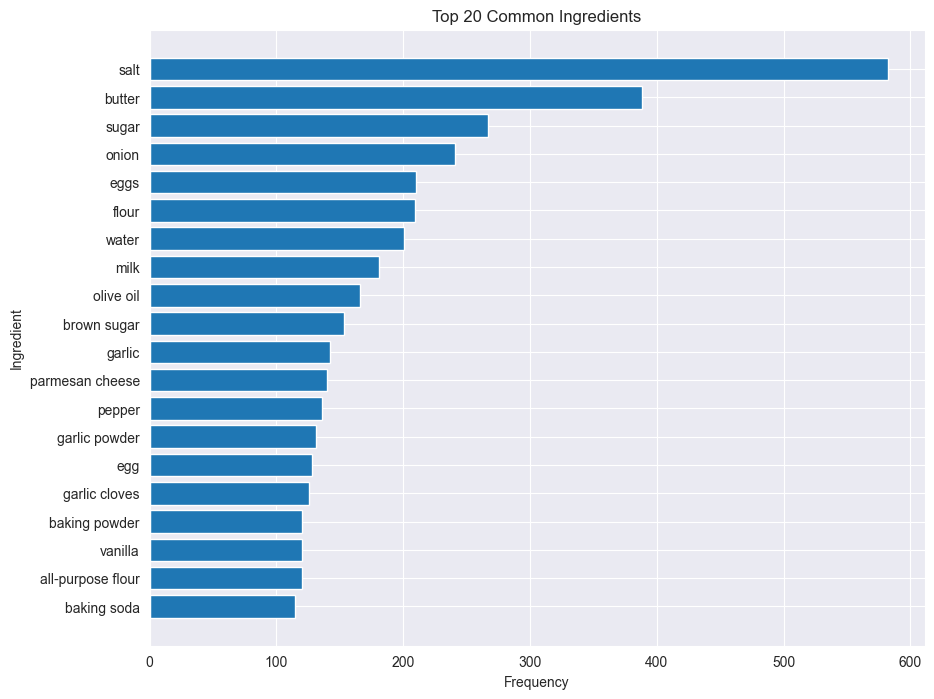

[('salt', 582), ('butter', 388), ('sugar', 267), ('onion', 241), ('eggs', 210), ('flour', 209), ('water', 201), ('milk', 181), ('olive oil', 166), ('brown sugar', 153), ('garlic', 142), ('parmesan cheese', 140), ('pepper', 136), ('garlic powder', 131), ('egg', 128), ('garlic cloves', 126), ('baking powder', 120), ('vanilla', 120), ('all-purpose flour', 120), ('baking soda', 115)]


In [3]:
def ingredient_frequency_analysis(data):
    all_ingredients = []
    for ingredients_list in data['ingredients']:
        all_ingredients.extend(ingredient.strip() for ingredient in ingredients_list)
    
    ingredient_counts = Counter(all_ingredients)
    common_ingredients = ingredient_counts.most_common(20)

    ingredient_df = pd.DataFrame(common_ingredients, columns=['Ingredient', 'Frequency'])
    #print("Top 20 common ingredients:\n", ingredient_df)
    
    # Plot the frequency of the top 20 ingredients
    plt.figure(figsize=(10, 8))
    plt.barh(ingredient_df['Ingredient'], ingredient_df['Frequency'])
    plt.xlabel('Frequency')
    plt.ylabel('Ingredient')
    plt.title('Top 20 Common Ingredients')
    plt.gca().invert_yaxis()
    plt.show()
    
    return common_ingredients



ingredient_freq_df = ingredient_frequency_analysis(data)
print(ingredient_freq_df)

In [2]:
from gensim.models import Word2Vec, KeyedVectors
from gensim.test.utils import datapath

wv = KeyedVectors.load_word2vec_format(datapath("GoogleNews-vectors-negative300.bin"), 
                                       binary=True)

simil = wv.similarity("mozzarella", "pasta")
print(simil)

0.6038335


In [ ]:
simil = wv.similarity("spaghetti", "pasta")
print(simil)

In [5]:
def preprocess_ingredients2(ingredients_str):
    ingredients_list = eval(ingredients_str)
    processed_ingredients = []
    regex = re.compile('[^a-zA-Z ]')
    lemmatizer = WordNetLemmatizer()
    #stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    # POS tags that represent nouns
    noun_tags = ['NN', 'NNS', 'NNP', 'NNPS']
    
    # Define the words to be dropped
    words_to_drop = {"powder", "brown", "salt", "water", "sugar", "onion", "butter", "pepper", "ground", "cream"} 

    for ingr in ingredients_list:
        ingr = regex.sub(' ', ingr.lower()).strip()
        components = [comp.strip() for comp in ingr.split('and')]
        

        for comp in components:
                        
            sentence = ""
            tokens = word_tokenize(comp)  # Tokenize each component
            tagged_tokens = pos_tag(tokens)  # Perform POS tagging
            
            # Extract main nouns while handling compound nouns
            nouns = []
            current_noun = ""
            for word, tag in tagged_tokens:
                word = lemmatizer.lemmatize(word.strip())
                if len(word) > 2 and word not in stop_words and word not in words_to_drop and tag in noun_tags:
                    if current_noun:
                        nouns.append(current_noun)
                        current_noun = ""
                    current_noun = word
            
            # Add last current noun if exists
            if current_noun:
                nouns.append(current_noun)
            
            
            # equal = False
            # for w1 in nouns:
            #     for w2 in ingredient_freq_df:
            #         #print(w1, w2[0])
            #         if w1 == w2[0]:
            #             equal = True
            #             break
            #         else:
            #            √ try:
            #                 for w2part in w2[0].split():
            #                     if w1 in wv and w2part in wv:
            #                         simil = wv.similarity(w1, w2part)
            #                         if simil > 0.9:
            #                             print('%r\t%r\t%r' % (w1, w2[0], simil))
            #             except KeyError:
            #                 print('%r\t%r\tNone' % (w1, w2[0]))
            
            
            for word in nouns:
                singular_comp = lemmatizer.lemmatize(word.strip())
                #stemmed_word = stemmer.stem(singular_comp)
            
                if singular_comp not in stop_words and len(singular_comp) > 2:
                    sentence += singular_comp + " "
                    
            if sentence.strip():
                processed_ingredients.append(sentence.strip())

    return list(set(processed_ingredients))

def load_and_preprocess_data2(file_path):
    data = pd.read_csv(file_path)
    data.columns = data.columns.str.strip()  # Remove any leading/trailing whitespace from column names

    # Preprocess ingredients to merge compound ingredients
    data['ingredients'] = data['ingredients'].apply(preprocess_ingredients2)
    return data

In [6]:
file_path = 'dataset/RAW_merged_top_smallest.csv'
data = load_and_preprocess_data2(file_path)

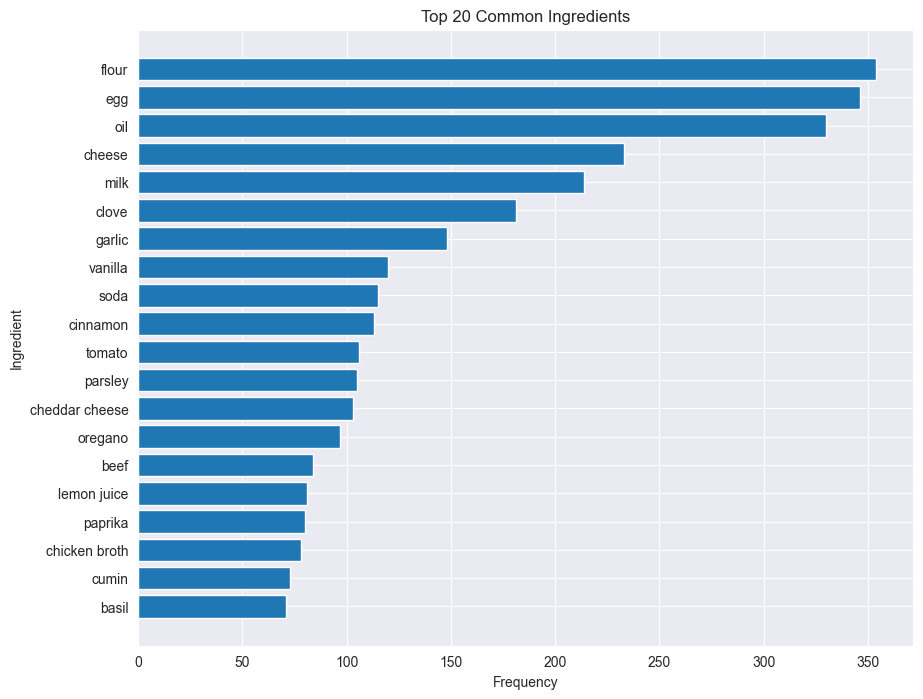

Counter({'flour': 354, 'egg': 346, 'oil': 330, 'cheese': 233, 'milk': 214, 'clove': 181, 'garlic': 148, 'vanilla': 120, 'soda': 115, 'cinnamon': 113, 'tomato': 106, 'parsley': 105, 'cheddar cheese': 103, 'oregano': 97, 'beef': 84, 'lemon juice': 81, 'paprika': 80, 'chicken broth': 78, 'cumin': 73, 'basil': 71, 'cayenne': 70, 'flake': 68, 'soy sauce': 62, 'mayonnaise': 61, 'vinegar': 60, 'chili': 58, 'carrot': 58, 'ginger': 58, 'celery': 57, 'potato': 56, 'thyme': 54, 'mustard': 53, 'worcestershire sauce': 51, 'breadcrumb': 50, 'tomato sauce': 50, 'vanilla extract': 49, 'cornstarch': 48, 'bean': 47, 'boneless skinless chicken breast': 46, 'honey': 44, 'margarine': 42, 'chocolate chip': 40, 'yeast': 40, 'bacon': 39, 'cocoa': 39, 'mozzarella cheese': 36, 'rice': 36, 'nutmeg': 35, 'bell': 33, 'mushroom soup': 33, 'bread': 32, 'mushroom': 32, 'ketchup': 31, 'pecan': 30, 'buttermilk': 30, 'walnut': 30, 'seasoning': 29, 'peanut': 29, 'cilantro': 29, 'chicken': 28, 'banana': 28, 'dijon mustard

In [7]:
def ingredient_frequency_analysis(data):
    all_ingredients = []
    for ingredients_list in data['ingredients']:
        all_ingredients.extend(ingredient.strip() for ingredient in ingredients_list)
    
    ingredient_counts = Counter(all_ingredients)
    common_ingredients = ingredient_counts.most_common(20)

    ingredient_df = pd.DataFrame(common_ingredients, columns=['Ingredient', 'Frequency'])
    #print("Top 20 common ingredients:\n", ingredient_df)
    
    # Plot the frequency of the top 20 ingredients
    plt.figure(figsize=(10, 8))
    plt.barh(ingredient_df['Ingredient'], ingredient_df['Frequency'])
    plt.xlabel('Frequency')
    plt.ylabel('Ingredient')
    plt.title('Top 20 Common Ingredients')
    plt.gca().invert_yaxis()
    plt.show()
    
    return ingredient_counts



ingredient_freq_df = ingredient_frequency_analysis(data)
print(ingredient_freq_df)

In [8]:
# Define the list of cooking techniques
TECHNIQUES_LIST = [
    'bake', 'barbecue', 'blanch', 'blend', 'boil', 'braise', 'brine', 'broil',
    'caramelize', 'combine', 'crock pot', 'crush', 'deglaze', 'devein', 'dice',
    'distill', 'drain', 'emulsify', 'ferment', 'freez', 'fry', 'grate', 'griddle',
    'grill', 'knead', 'leaven', 'marinate', 'mash', 'melt', 'microwave', 'parboil',
    'pickle', 'poach', 'pour', 'pressure cook', 'puree', 'refrigerat', 'roast', 'saute',
    'scald', 'scramble', 'shred', 'simmer', 'skillet', 'slow cook', 'smoke', 'smooth',
    'soak', 'sous-vide', 'steam', 'stew', 'strain', 'tenderize', 'thicken', 'toast',
    'toss', 'whip', 'whisk'
]

# Convert one-hot encoding array to list of techniques
def one_hot_to_techniques(one_hot_array):
    techniques = [TECHNIQUES_LIST[i] for i, val in enumerate(one_hot_array) if val == 1]
    return techniques

# Convert the one-hot encoded 'techniques' column to a list of techniques
def convert_techniques_column(data):
    data['techniques_list'] = data['techniques'].apply(eval).apply(one_hot_to_techniques)
    return data

import scipy
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
    
# Cooking method clustering based on techniques
def cooking_method_clustering(data):
    data = convert_techniques_column(data)
    data['techniques_str'] = data['techniques_list'].apply(lambda x: ' '.join(x))
    
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(data['techniques_str'])

    pca = PCA(n_components=2)
    components = pca.fit_transform(X.toarray())
    
    """
    #Use Elbow method to determine optimal number of clusters
    # https://pythonprogramminglanguage.com/kmeans-elbow-method/
    plt.figure()
    # k means determine k
    distortions = []
    K = range(1,15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(components)
        distortions.append(sum(np.min(cdist(components, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / components.shape[0])
     
    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    """

    kmeans = KMeans(n_clusters=4, random_state=42)
    clusters = kmeans.fit_predict(components)
    
    data['cluster'] = clusters
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=clusters, palette="viridis")
    plt.title("Cooking Method Clustering")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()
    
    cluster_rating_df = data.groupby('cluster')['avg_rating'].mean().reset_index()
    print(cluster_rating_df)
    
    return data, cluster_rating_df


#clustered_data, cluster_rating_df = cooking_method_clustering(data)

In [9]:
def pairwise_ingredient_correlation(data):
    pair_counts = Counter()
    for ingredients_list in data['ingredients']:
        ingredient_list = [ingredient.strip() for ingredient in ingredients_list]
        pairs = combinations(ingredient_list, 2)
        pair_counts.update(pairs)
    
    common_pairs = pair_counts.most_common(20)
    pair_df = pd.DataFrame(common_pairs, columns=['Pair', 'Frequency'])
    pair_df['Ingredient1'] = pair_df['Pair'].apply(lambda x: x[0])
    pair_df['Ingredient2'] = pair_df['Pair'].apply(lambda x: x[1])
    pair_df.drop(columns=['Pair'], inplace=True)
    
    print("Top 20 common ingredient pairs:\n", pair_df)
    
    # Plot the frequency of the top 20 ingredient pairs
    plt.figure(figsize=(14, 10))
    sns.barplot(x='Frequency', y='Ingredient1', hue='Ingredient2', data=pair_df, dodge=False)
    plt.xlabel('Frequency')
    plt.ylabel('Ingredient Pair')
    plt.title('Top 20 Common Ingredient Pairs')
    plt.show()
    
    return pair_df

#pairwise_ingredient_df = pairwise_ingredient_correlation(data)

Performing Ingredient Frequency Analysis...


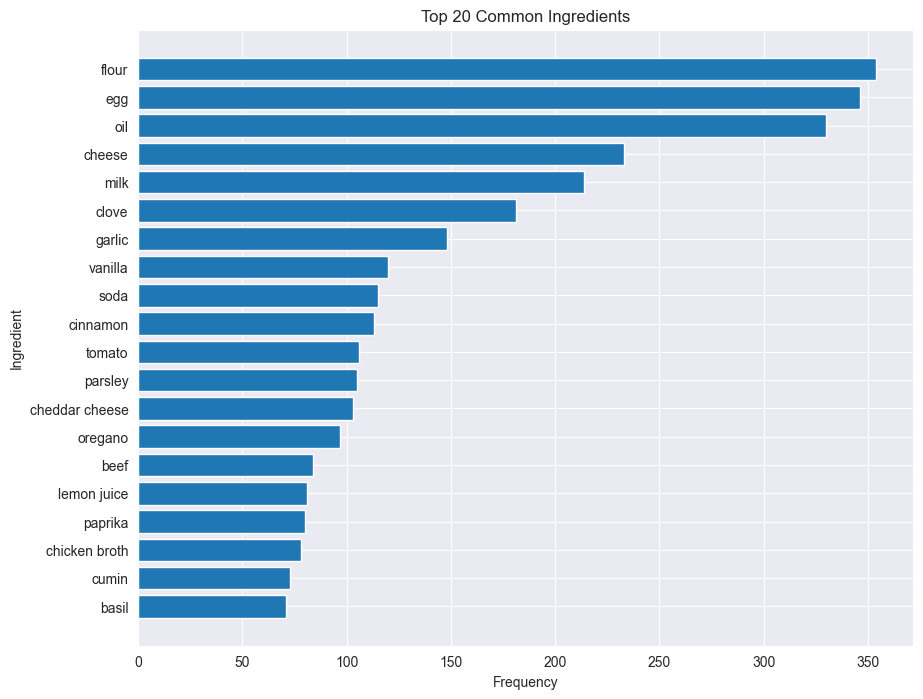


Performing Cooking Method Clustering...


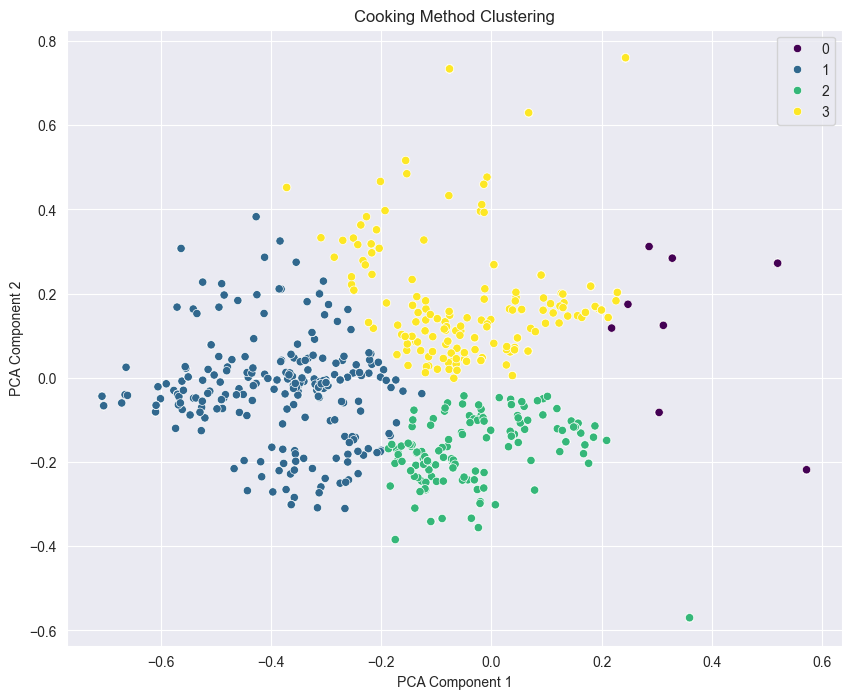

   cluster  avg_rating
0        0    4.588945
1        1    4.608181
2        2    4.598646
3        3    4.611256

Performing Pairwise Ingredient Correlation...
Top 20 common ingredient pairs:
     Frequency Ingredient1 Ingredient2
0         130       flour         egg
1          97         oil       flour
2          96     vanilla         egg
3          94        milk         egg
4          89        milk       flour
5          87         oil         egg
6          85     vanilla       flour
7          79         oil       clove
8          71        soda         egg
9          71         egg       flour
10         69         oil      garlic
11         66       flour    cinnamon
12         63         egg    cinnamon
13         62       flour        soda
14         58         oil      cheese
15         56     vanilla        soda
16         45        soda       flour
17         44      cheese         egg
18         44      cheese      garlic
19         43         oil     oregano


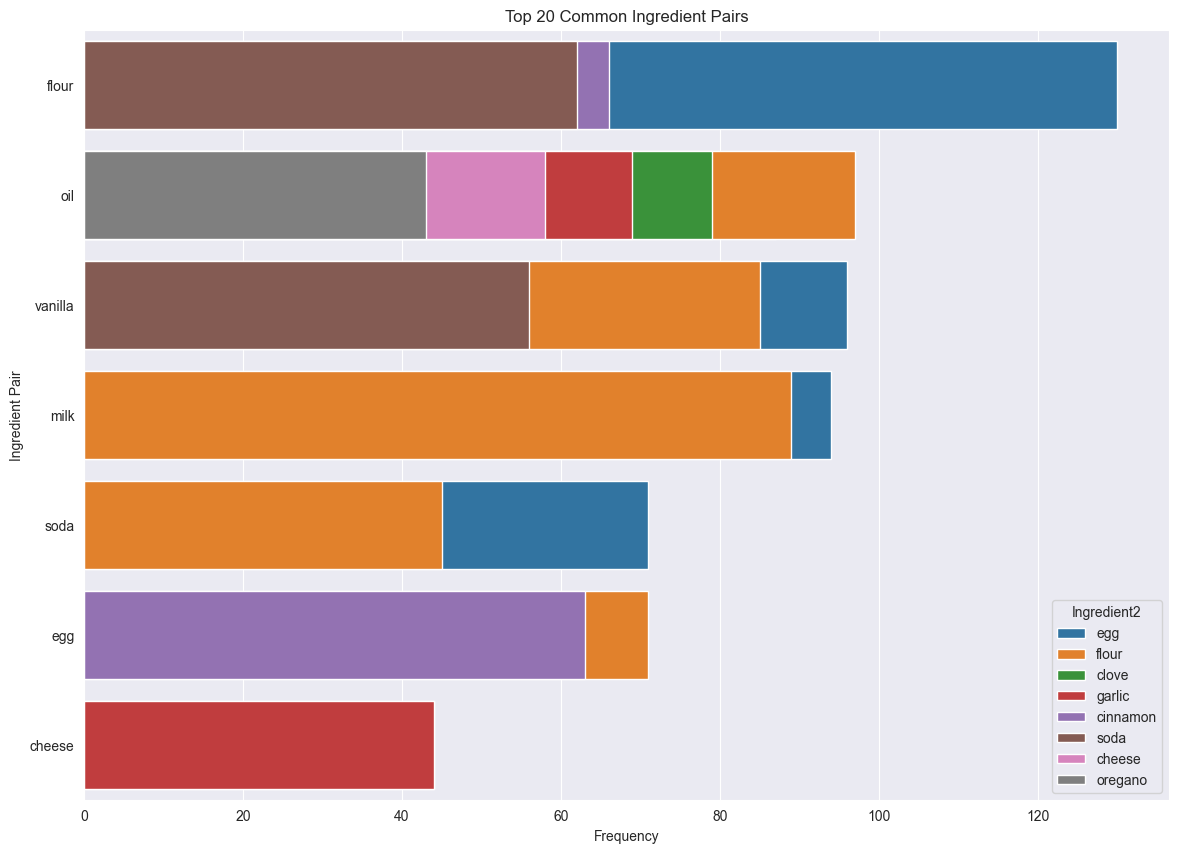

In [10]:
def advanced_correlation_analysis(data):
    print("Performing Ingredient Frequency Analysis...")
    ingredient_freq_df = ingredient_frequency_analysis(data)
    
    print("\nPerforming Cooking Method Clustering...")
    clustered_data, cluster_rating_df = cooking_method_clustering(data)
    
    print("\nPerforming Pairwise Ingredient Correlation...")
    pairwise_ingredient_df = pairwise_ingredient_correlation(data)
    
    
    return ingredient_freq_df, cluster_rating_df, pairwise_ingredient_df

# Run advanced correlation analysis
ingredient_freq_df, cluster_rating_df, pairwise_ingredient_df = advanced_correlation_analysis(data)